In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
ads_data = pd.read_csv('ads_data.csv',parse_dates=['date','time'])

In [12]:
ads_clients_data = pd.read_csv('ads_clients_data.csv',parse_dates=['date','create_date'])

In [13]:
ads_data.head()

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269
1,2019-04-01,2019-04-01 00:00:48,view,web,121288,121288,121288,CPM,187.4,0,232011
2,2019-04-01,2019-04-01 00:01:03,view,android,102737,102535,102564,CPC,60.7,0,4410
3,2019-04-01,2019-04-01 00:01:03,view,android,107564,106914,107564,CPM,217.3,0,62711
4,2019-04-01,2019-04-01 00:01:09,view,android,4922,37,4400,CPC,60.1,0,1183501


In [14]:
ads_clients_data.head()

,date,client_union_id,community_id,create_date
0,2020-05-07,1,-130371893,2018-12-24
1,2020-05-07,2,-130304626,2019-02-10
2,2020-05-07,3,-130462599,2019-01-25
3,2020-05-07,4,-130574300,2018-12-09
4,2020-05-07,5,-130292358,2019-01-08


Для начала посчитаем среднее количество разных рекламных событий (показы и клики) по объявлениям. Тонкий момент: помните, что некоторые показываемые объявления не кликались, и при группировке в таких случаях не будет строк с кликами, а для подсчёта среднего по объявлениям их нужно учитывать. Округлите ответы до целых чисел.

In [15]:
a = ads_data.groupby(['ad_id','event'], as_index = False).agg({'time':'count'}).pivot(index = 'ad_id',columns = 'event', values = 'time').fillna(0)

In [16]:
a

event,click,view
ad_id,,
2,1.0,101.0
3,3.0,184.0
1902,1.0,41.0
2064,0.0,35.0
2132,1.0,58.0
...,...,...
122004,4.0,100.0
122013,0.0,156.0
122023,0.0,68.0


In [17]:
round(a.mean(),2)

event
click    113.14
view     923.13
dtype: float64

Давайте посмотрим на распределение показов объявлений
По оси x – число показов
По оси y – доля объявлений с такими показами

In [18]:
df = ads_data.query("event == 'view'").ad_id.value_counts()

In [19]:
log_v = np.log(df)

In [20]:
log_v

112583    12.770824
107729    12.125925
107837    10.858922
28142     10.092122
45008      9.886748
            ...    
110591     2.564949
45969      2.564949
112872     2.397895
42507      2.397895
98274      2.302585
Name: ad_id, Length: 956, dtype: float64

In [21]:
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
        )

<AxesSubplot:xlabel='ad_id', ylabel='Density'>

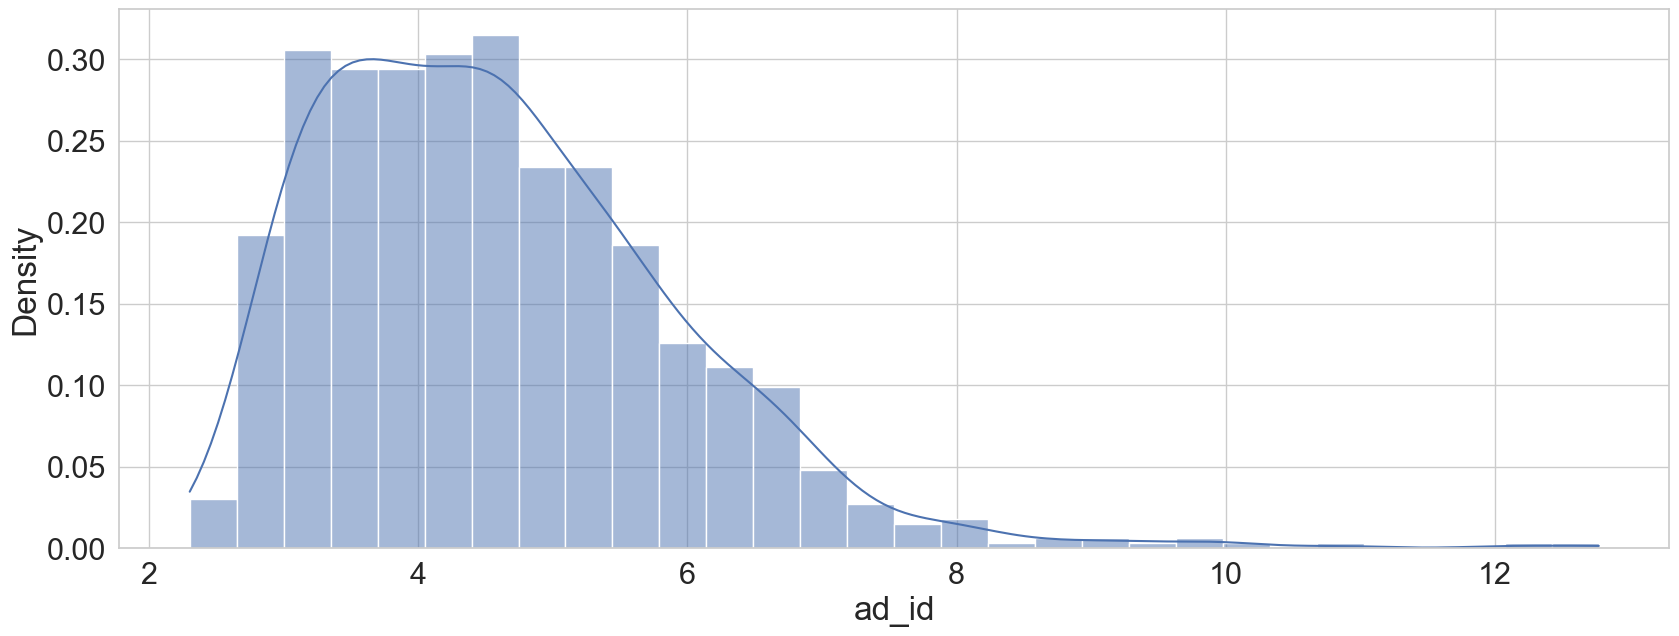

In [22]:
sns.histplot(data = log_v ,stat='density', kde=True)

Теперь нужно найти среднее количество показов на 1 объявление (ad_id) по дням, не учитывая объявления, у которых не было показов (обычное среднее). После этого посчитайте скользящее среднее по полученному результату с окном в 2 элемента.

In [23]:
df = ads_data.query("event == 'view'").groupby(['date','ad_id'],as_index = [False,False])\
.agg({'event':'count'}).reset_index()

In [24]:
df_f = df.groupby('date',as_index = False).agg({'event':'mean'}).round()

In [25]:
df_f['roll']= df_f.event.rolling(window = 2).mean()

In [26]:
df_f

,date,event,roll
0,2019-04-01,154.0,NaN
1,2019-04-02,138.0,146.0
2,2019-04-03,164.0,151.0
3,2019-04-04,676.0,420.0
4,2019-04-05,919.0,797.5
5,2019-04-06,277.0,598.0


Скользящее среднее часто используется для поиска аномалий в данных. Давайте попробуем нанести на один график значения просто среднего количества показов по дням и скользящего среднего на основе этих данных (которое мы получили в прошлом задании).

<AxesSubplot:xlabel='date', ylabel='event'>

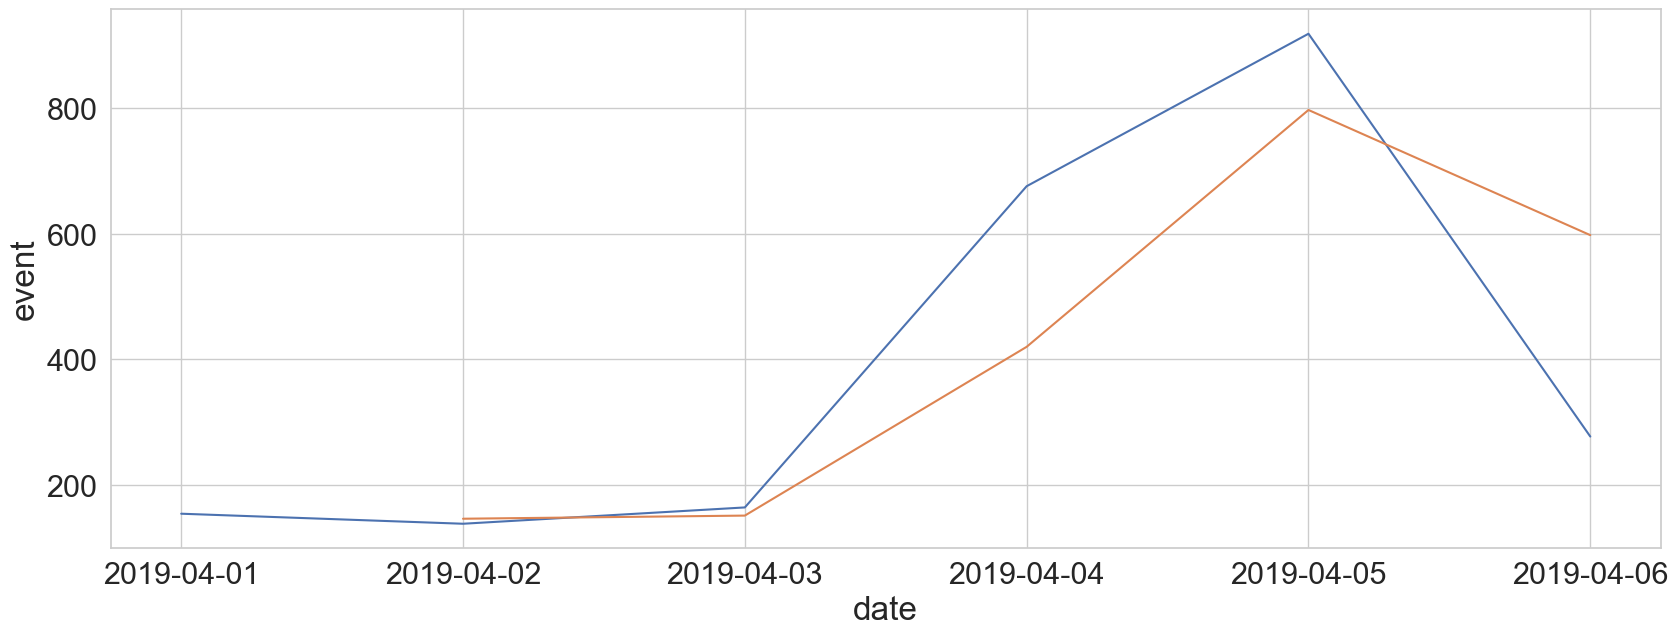

In [27]:
sns.set(
font_scale = 2 ,
style = 'whitegrid' ,
rc = {'figure.figsize' : (20,7)}
)
sns.lineplot(x ='date', y ='event',data = df_f)
sns.lineplot(x ='date', y ='roll',data = df_f)

Объедините данные рекламы с данными о рекламных клиентах и найдите среднее количество дней от даты создания рекламного клиента (create_date) и первым запуском рекламного объявления этим клиентом (date).

В качестве ответа укажите среднее число дней.

In [28]:
mer = ads_data.merge(ads_clients_data, how='inner', on='client_union_id', suffixes=['_ad','_cl'])

In [29]:
mer.head()

,date_ad,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count,date_cl,community_id,create_date
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04
1,2019-04-01,2019-04-01 00:03:28,view,android,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04
2,2019-04-01,2019-04-01 00:04:58,view,ios,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04
3,2019-04-01,2019-04-01 00:10:23,view,ios,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04
4,2019-04-01,2019-04-01 00:15:42,view,android,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04


In [30]:
mer['diff'] = mer['date_ad'] - mer['create_date']

In [31]:
mer.groupby('client_union_id').agg({'diff':'min'}).mean()

diff   124 days 09:04:43.532219570
dtype: timedelta64[ns]

Давайте вычислим конверсию из создания рекламного кабинета в запуск первой рекламы в течение не более 365 дней.

In [32]:
th = pd.Timedelta(365, unit='day')

In [33]:
fa = mer.groupby('client_union_id',as_index=False).agg({'diff':'min'})

In [34]:
cl_365 = fa[fa['diff']<th]

In [35]:
round(cl_365.shape[0]/ads_clients_data.client_union_id.nunique()*100,2)

0.69

Давайте разобъем наших клиентов по промежуткам от создания рекламного кабинета до запуска первого рекламного объявления.

Определите, сколько уникальных клиентов запустили свое первое объявление в первый месяц своего существования (от 0 до 30 дней). Список промежутков дней [0, 30, 90, 180, 365].

In [36]:
b = [0, 30, 90, 180, 365]

In [37]:
b = [pd.to_timedelta(x, 'd') for x in b]

In [38]:
b

[Timedelta('0 days 00:00:00'),
 Timedelta('30 days 00:00:00'),
 Timedelta('90 days 00:00:00'),
 Timedelta('180 days 00:00:00'),
 Timedelta('365 days 00:00:00')]

In [39]:
l = ['0-30','30-90','90-180','180-365']

In [40]:
bl = pd.cut(fa['diff'],b,labels=l)

In [41]:
bl

0      90-180
1      90-180
2       30-90
3      90-180
4       30-90
        ...  
833     30-90
834    90-180
835    90-180
836    90-180
837     30-90
Name: diff, Length: 838, dtype: category
Categories (4, object): ['0-30' < '30-90' < '90-180' < '180-365']

In [48]:
bl.value_counts()

90-180     396
30-90      263
180-365    168
0-30        11
Name: diff, dtype: int64